In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
m = 100                     # 5, 50, 100, 500, 2000

In [3]:
train_size = 100           # 100, 500, 2000, 10000

In [4]:
desired_num = train_size + 1000

In [5]:
tr_i = 0
tr_j = train_size
tr_k = desired_num

tr_i, tr_j, tr_k

(0, 100, 1100)

# Generate dataset

In [6]:
np.random.seed(1)
n_points = 500
y = np.concatenate((np.zeros(n_points),np.ones(n_points),np.ones(n_points)*2,np.ones(n_points)*3,np.ones(n_points)*4,
                    np.ones(n_points)*5,np.ones(n_points)*6,np.ones(n_points)*7,np.ones(n_points)*8,np.ones(n_points)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [7]:
x = np.zeros((n_points*10,5))

In [8]:
np.random.seed(1)
cov_mat = [[0.02,0,0,0,0],[0,0.02,0,0,0],[0,0,0.02,0,0],
                                                 [0,0,0,0.02,0],[0,0,0,0,0.02]]

x[idx[0],:] = np.random.multivariate_normal(mean = [1,0,0,0,0],
                                            cov=cov_mat,size=sum(idx[0]))


x[idx[1],:] = np.random.multivariate_normal(mean = [0,1,0,0,0],
                                            cov=cov_mat,size=sum(idx[1]))


x[idx[2],:] = np.random.multivariate_normal(mean = [0,0,1,0,0],
                                            cov=cov_mat,size=sum(idx[2]))


x[idx[3],:] = np.random.multivariate_normal(mean = [0,0,0,-0.75,0.5],
                                            cov=cov_mat,size=sum(idx[3]))



x[idx[4],:] = np.random.multivariate_normal(mean = [0,0,0,0.65,-0.65],
                                            cov=cov_mat,size=sum(idx[4]))


x[idx[5],:] = np.random.multivariate_normal(mean = [0,0,0,-0.9,-0.75],
                                            cov=cov_mat,size=sum(idx[5]))


x[idx[6],:] = np.random.multivariate_normal(mean = [0,0,0,0.8,-0.8],
                                            cov=cov_mat,size=sum(idx[6]))

x[idx[7],:] = np.random.multivariate_normal(mean = [0,0,0,-0.5,0.8],
                                            cov=cov_mat,size=sum(idx[7]))


x[idx[8],:] = np.random.multivariate_normal(mean = [0,0,0,0.9,0.75],
                                            cov=cov_mat,size=sum(idx[8]))


x[idx[9],:] = np.random.multivariate_normal(mean = [0,0,0,-1,0.65],
                                            cov=cov_mat,size=sum(idx[9]))

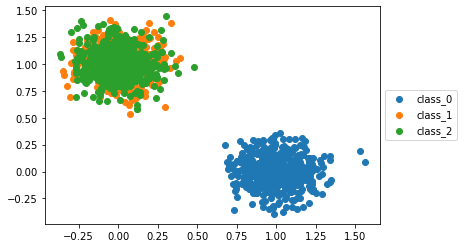

In [9]:
plt.scatter(x[idx[0],0],x[idx[0],1],label="class_"+str(0))

plt.scatter(x[idx[1],0],x[idx[1],1],label="class_"+str(1))



plt.scatter(x[idx[2],1],x[idx[2],2],label="class_"+str(2))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
print(np.mean(x)),print(np.std(x))

0.05488034032428808
0.4852598614616613


(None, None)

In [11]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3500,)

In [12]:
np.unique(bg_idx).shape

(3500,)

In [13]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [14]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[ 5.13874657e-18, -1.12608335e-18,  3.40204055e-18,
         -1.36398829e-16,  1.37255287e-16]]),
 array([[ 0.10018249,  0.10092463,  0.10053439,  0.03500096, -0.02430054]]))

In [15]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [16]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1., 1., 1., 1.]]),
 array([[2.33693198, 2.31727908, 2.36731988, 0.84494646, 0.84569432]]))

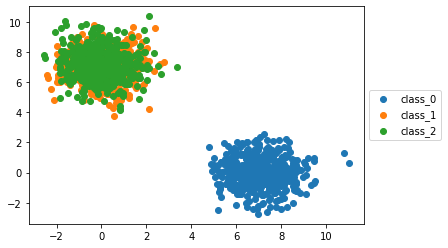

In [44]:
plt.scatter(x[idx[0],0],x[idx[0],1],label="class_"+str(0))
plt.scatter(x[idx[1],0],x[idx[1],1],label="class_"+str(1))
plt.scatter(x[idx[2],1],x[idx[2],2],label="class_"+str(2))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [18]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [19]:
desired_num = 1100  # 2000 + 1000


m = 100



mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,5)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1100/1100 [00:02<00:00, 375.55it/s]


In [20]:
len(mosaic_list_of_images),mosaic_list_of_images[0].shape

(1100, (100, 5))

In [21]:
mosaic_list_of_images[0].shape

(100, 5)

In [22]:
def create_avg_image_from_mosaic_dataset(mosaic_dataset,labels,foreground_index,dataset_number, m):
  """
  mosaic_dataset : mosaic_dataset contains 9 images 32 x 32 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  dataset_number : will help us to tell what ratio of foreground image to be taken. for eg: if it is "j" then fg_image_ratio = j/9 , bg_image_ratio = (9-j)/8*9
  """
  avg_image_dataset = []
  cnt = 0
  counter = np.zeros(m) #np.array([0,0,0,0,0,0,0,0,0])
  for i in range(len(mosaic_dataset)):
    img = torch.zeros([5], dtype=torch.float64)
    np.random.seed(int(dataset_number*10000 + i))
    give_pref = foreground_index[i] #np.random.randint(0,9)
    # print("outside", give_pref,foreground_index[i])
    for j in range(m):
      if j == give_pref:
        img = img + mosaic_dataset[i][j]*dataset_number/m   #2 is data dim
      else :
        img = img + mosaic_dataset[i][j]*(m-dataset_number)/((m-1)*m)

    if give_pref == foreground_index[i] :
      # print("equal are", give_pref,foreground_index[i])
      cnt += 1
      counter[give_pref] += 1
    else :
      counter[give_pref] += 1

    avg_image_dataset.append(img)

  print("number of correct averaging happened for dataset "+str(dataset_number)+" is "+str(cnt)) 
  print("the averaging are done as ", counter) 
  return avg_image_dataset , labels , foreground_index
        
  

In [23]:
avg_image_dataset_1 , labels_1,  fg_index_1 = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[0:tr_j], mosaic_label[0:tr_j], fore_idx[0:tr_j] , 1, m)


test_dataset , labels , fg_index = create_avg_image_from_mosaic_dataset(mosaic_list_of_images[tr_j : tr_k], mosaic_label[tr_j : tr_k], fore_idx[tr_j : tr_k] , m, m)

number of correct averaging happened for dataset 1 is 100
the averaging are done as  [0. 0. 2. 3. 2. 3. 0. 2. 0. 0. 0. 2. 3. 0. 0. 6. 0. 0. 1. 3. 0. 0. 0. 2.
 2. 1. 1. 0. 1. 1. 0. 1. 2. 0. 2. 4. 0. 1. 2. 1. 1. 2. 2. 0. 1. 1. 2. 1.
 1. 0. 0. 2. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 2. 2. 2. 1. 0. 0. 0. 2. 0. 1.
 1. 1. 2. 2. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 2. 1. 0. 1. 1. 3. 2. 0. 0. 0.
 2. 0. 2. 0.]
number of correct averaging happened for dataset 100 is 1000
the averaging are done as  [13.  8.  7. 12.  8. 13. 10.  8.  4. 14.  9. 13. 13.  9.  8.  8. 14. 11.
 13.  9. 14.  6.  9. 12.  8.  6. 19.  7. 13. 10. 16. 11.  9. 11.  6. 12.
  3.  7.  8.  8.  9.  9.  6.  8.  5.  9. 17.  7. 12. 10. 10.  6. 11.  3.
 11. 13. 11.  9. 15.  7. 11. 15. 14.  5. 13.  8. 13.  5. 13. 13. 15. 11.
 10.  8.  8. 10. 14.  8.  9.  6. 16. 12. 10. 12.  8.  6. 11. 10.  8.  7.
 12.  5. 14. 12. 11. 13.  8. 10.  9. 10.]


In [24]:
avg_image_dataset_1 = torch.stack(avg_image_dataset_1, axis = 0)
# avg_image_dataset_1 = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
# print(torch.mean(avg_image_dataset_1, keepdims= True, axis = 0))
# print(torch.std(avg_image_dataset_1, keepdims= True, axis = 0))
print("=="*40)


test_dataset = torch.stack(test_dataset, axis = 0)
# test_dataset = (avg - torch.mean(avg, keepdims= True, axis = 0)) / torch.std(avg, keepdims= True, axis = 0)
# print(torch.mean(test_dataset, keepdims= True, axis = 0))
# print(torch.std(test_dataset, keepdims= True, axis = 0))
print("=="*40)


Text(0.5, 1.0, 'dataset4 CIN with alpha = 1/100')

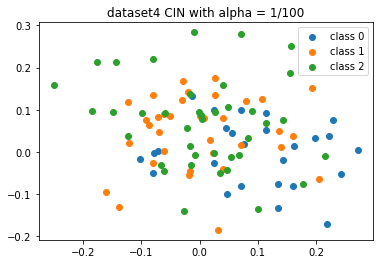

In [45]:
x1 = (avg_image_dataset_1).numpy()
y1 = np.array(labels_1)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,1], x1[y1==2,2], label='class 2')
plt.legend()
plt.title("dataset4 CIN with alpha = 1/"+str(m))

Text(0.5, 1.0, 'test dataset4')

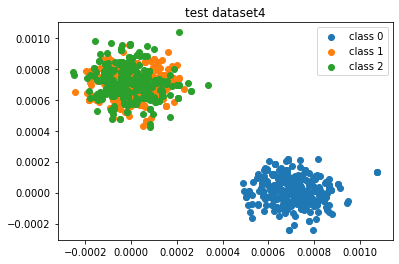

In [46]:
x1 = (test_dataset).numpy() / m
y1 = np.array(labels)

plt.scatter(x1[y1==0,0], x1[y1==0,1], label='class 0')
plt.scatter(x1[y1==1,0], x1[y1==1,1], label='class 1')
plt.scatter(x1[y1==2,1], x1[y1==2,2], label='class 2')
plt.legend()
plt.title("test dataset4")

In [27]:
test_dataset[0:10]/m

tensor([[ 7.7676e-02,  1.2855e-02, -6.0716e-03,  2.4828e-03,  1.7194e-03],
        [ 7.7715e-03,  7.1691e-02, -7.8548e-03,  1.4859e-03, -3.4290e-03],
        [ 5.6940e-02,  3.1087e-03,  8.6347e-03, -1.5126e-04, -3.8060e-04],
        [-2.1565e-04,  7.4080e-02,  3.0682e-03,  5.3280e-03, -3.0801e-03],
        [-1.0016e-02,  8.7415e-02,  1.9229e-02,  1.8830e-03,  5.7905e-04],
        [ 6.3830e-02,  2.2499e-03,  9.4223e-03, -1.3579e-03, -1.2631e-04],
        [-1.6413e-03, -2.6859e-03,  7.4782e-02,  3.6815e-03, -2.0005e-03],
        [ 2.0942e-02, -9.8198e-03,  8.0651e-02,  1.6456e-03, -2.7235e-03],
        [-3.0752e-03,  7.2593e-02, -2.2906e-02,  1.7757e-03, -3.0539e-03],
        [ 5.1579e-03, -1.0245e-02,  6.8593e-02, -3.6424e-04, -4.2169e-05]],
       dtype=torch.float64)

In [28]:
test_dataset = test_dataset/m
test_dataset[0:10]

tensor([[ 7.7676e-02,  1.2855e-02, -6.0716e-03,  2.4828e-03,  1.7194e-03],
        [ 7.7715e-03,  7.1691e-02, -7.8548e-03,  1.4859e-03, -3.4290e-03],
        [ 5.6940e-02,  3.1087e-03,  8.6347e-03, -1.5126e-04, -3.8060e-04],
        [-2.1565e-04,  7.4080e-02,  3.0682e-03,  5.3280e-03, -3.0801e-03],
        [-1.0016e-02,  8.7415e-02,  1.9229e-02,  1.8830e-03,  5.7905e-04],
        [ 6.3830e-02,  2.2499e-03,  9.4223e-03, -1.3579e-03, -1.2631e-04],
        [-1.6413e-03, -2.6859e-03,  7.4782e-02,  3.6815e-03, -2.0005e-03],
        [ 2.0942e-02, -9.8198e-03,  8.0651e-02,  1.6456e-03, -2.7235e-03],
        [-3.0752e-03,  7.2593e-02, -2.2906e-02,  1.7757e-03, -3.0539e-03],
        [ 5.1579e-03, -1.0245e-02,  6.8593e-02, -3.6424e-04, -4.2169e-05]],
       dtype=torch.float64)

In [29]:
test_dataset.shape

torch.Size([1000, 5])

In [30]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [31]:
avg_image_dataset_1[0].shape
avg_image_dataset_1[0]

tensor([-0.0716,  0.0029, -0.0547, -0.1013, -0.0230], dtype=torch.float64)

In [32]:
batch = 200

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [33]:
testdata_1 = MosaicDataset(test_dataset, labels )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)


In [34]:
# testdata_11 = MosaicDataset(test_dataset, labels )
# testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [35]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(5,3)
        # self.linear2 = nn.Linear(50,3)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        # torch.nn.init.xavier_normal_(self.linear2.weight)
        # torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
        # x = F.relu(self.linear1(x))
        x = (self.linear1(x))

        return x

In [36]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to(device),labels.to(device)
      outputs = model(inputs)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [37]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [38]:
def train_all(trainloader, ds_number, testloader_list, lr_list):
  
  final_loss = []
  for LR in lr_list:    
    print("--"*20, "Learning Rate used is", LR)
    
    torch.manual_seed(12)
    net = Whatnet().double()
    net = net.to(device)
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=LR ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
        
    print("print parameters ")
    print(" ")
    
    for p in net.parameters():
        print(p)
    
    print("--"*40)
    
    final_loss.append(loss_curi) 
  return final_loss
    

In [39]:
train_loss_all=[]

testloader_list= [ testloader_1]
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5 ]

In [40]:
fin_loss = train_all(trainloader_1, 1, testloader_list, lr_list)
train_loss_all.append(fin_loss)

---------------------------------------- Learning Rate used is 0.0001
epoch: [0 ] loss: 1.132
epoch: [1] loss: 1.132
epoch: [201] loss: 1.127
epoch: [401] loss: 1.122
epoch: [601] loss: 1.118
epoch: [801] loss: 1.114
Finished Training
Accuracy of the network on the 100 train images: 30.00 %
unique out:  [0 1 2] unique pred:  [1 2]
correct:  4 total  1000
Accuracy of the network on the 1000 test dataset 1: 0.40 %
print parameters 
 
Parameter containing:
tensor([[ 0.5058, -0.0849, -0.1438,  0.9772, -0.4792],
        [ 0.3040, -0.5425,  0.0121,  0.1589,  0.0196],
        [ 0.4535,  0.6407, -0.7090, -0.6464,  0.4228]], dtype=torch.float64,
       requires_grad=True)
Parameter containing:
tensor([-0.0873,  0.0712,  0.0909], dtype=torch.float64, requires_grad=True)
--------------------------------------------------------------------------------
---------------------------------------- Learning Rate used is 0.0005
epoch: [0 ] loss: 1.132
epoch: [1] loss: 1.132
epoch: [201] loss: 1.110
epoch:

In [41]:
%matplotlib inline

In [42]:
len(fin_loss)

8

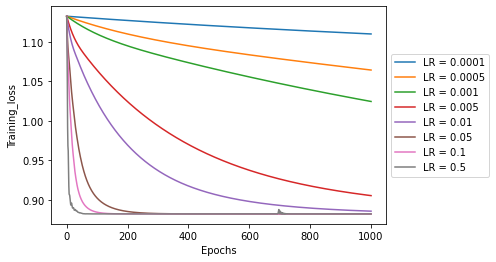

In [43]:
for i,j in enumerate(fin_loss):
    plt.plot(j,label ="LR = "+str(lr_list[i]))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))